In [1]:
import joblib

sa_vec = joblib.load("sa_vectorizer.joblib")
esa_vec = joblib.load("esa_vectorizer.joblib")

print("sa vectorizer vocab size:", len(sa_vec.get_feature_names_out()))
print("esa vectorizer vocab size:", len(esa_vec.get_feature_names_out()))

sa vectorizer vocab size: 10000
esa vectorizer vocab size: 10000


In [15]:
def load_txt_lines(path):
    with open(path, encoding="utf-8") as f:
        return [line.strip() for line in f if line.strip()]

train_medium = load_txt_lines("math/train-medium/arithmetic__div.txt")
# Similarly load train-medium, train-hard, test, etc.

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

# For standalone TF‑IDF transformation:
X_train_sa = sa_vec.transform(train_medium)
X_train_esa = esa_vec.transform(train_medium)

print("SA matrix shape:", X_train_sa.shape)
print("ESA matrix shape:", X_train_esa.shape)

SA matrix shape: (1333332, 10000)
ESA matrix shape: (1333332, 10000)


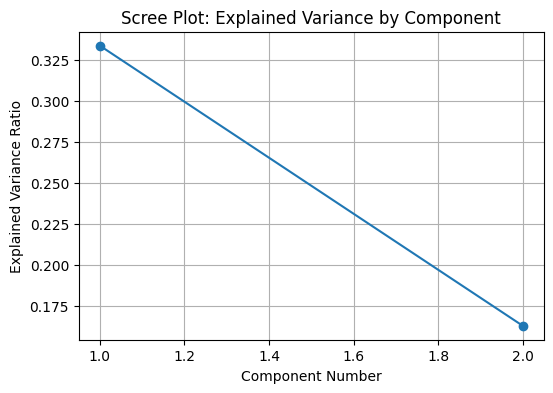

In [4]:
# Test for variance
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

svd = TruncatedSVD(n_components=2)
coords = svd.fit_transform(X_train_esa)
ratios = svd.explained_variance_ratio_

plt.figure(figsize=(6,4))
plt.plot(range(1, len(ratios)+1), ratios, 'o-')
plt.title("Scree Plot: Explained Variance by Component")
plt.xlabel("Component Number")
plt.ylabel("Explained Variance Ratio")
plt.grid(True)
plt.show()

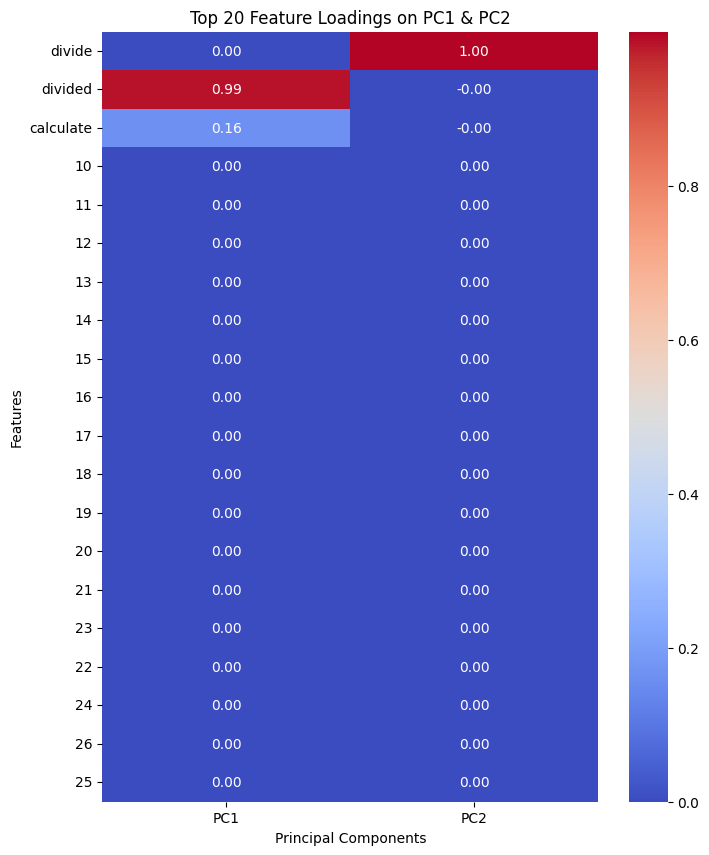

In [5]:
import pandas as pd
import seaborn as sns

loadings = svd.components_.T  # shape: (n_features × 2)
feature_names = esa_vec.get_feature_names_out()  # your concept names

df_load = pd.DataFrame(loadings, index=feature_names, columns=["PC1", "PC2"])
top = df_load.abs().sum(axis=1).sort_values(ascending=False).head(20)
df_top = df_load.loc[top.index]

plt.figure(figsize=(8,10))
sns.heatmap(df_top, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Top 20 Feature Loadings on PC1 & PC2")
plt.xlabel("Principal Components")
plt.ylabel("Features")
plt.show()


In [20]:
import glob
import os

label_paths = glob.glob("math/interpolate/*.txt")
labels = []

for path in label_paths:
    label = os.path.basename(os.path.dirname(path))  
    labels.append(label)

print(f"Found {len(labels)} labels from interpolate/")

Found 56 labels from interpolate/


In [23]:
X = sa_vec.transform(docs) 
X = X.toarray()
X = X[-len(y):] 

In [24]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y = encoder.fit_transform(labels)  # to numeric

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Prototype run
model = Sequential([
    Dense(128, activation='relu', input_shape=(X.shape[1],)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Use softmax and more units for multiclass
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 4. Train the model
model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)

/home/rc/dataproblems/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-27 05:53:46.532932: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - accuracy: 0.6222 - loss: 0.6900 - val_accuracy: 1.0000 - val_loss: 0.6713
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 1.0000 - loss: 0.6645 - val_accuracy: 1.0000 - val_loss: 0.6506
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 1.0000 - loss: 0.6373 - val_accuracy: 1.0000 - val_loss: 0.6302
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 1.0000 - loss: 0.6129 - val_accuracy: 1.0000 - val_loss: 0.6099
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 0.5898 - val_accuracy: 1.0000 - val_loss: 0.5892
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 1.0000 - loss: 0.5642 - val_accuracy: 1.0000 - val_loss: 0.5679
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 1.0000 - loss: 0.5424 - val_accuracy: 1.0000 - val_loss: 0.5461
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 1.0000 - loss: 0.5123 - val_accuracy: 1.0000 - val_loss: 0.524

In [29]:
text = [
    "What is the derivative of x^2?",
    "Solve for x: 2x + 3 = 7"
]

In [31]:
test = sa_vec.transform(text).toarray()

In [32]:
probs = model.predict(test)  # binary classification test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


In [33]:
preds = (probs > 0.5).astype(int)

In [34]:
new_texts = ["What is 2+2?", "Find the integral of sin(x)"]

X_new = sa_vec.transform(new_texts).toarray()
probs = model.predict(X_new)
preds = (probs > 0.5).astype(int)

print("Predicted class indices:", preds.flatten())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted class indices: [0 0]


In [38]:
# Check I/O
with open("math/train-medium/numbers__place_value.txt", encoding="utf-8") as f:
    print(f.read())

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

